In [2]:
import pickle
import argparse
import itertools

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy

import sys
sys.path.append('../scripts/observation')

import tinystories as ts

INFO 10-05 14:15:58 __init__.py:190] Automatically detected platform cpu.


In [3]:
def z_to_p(z_score):
    return scipy.stats.norm.sf(z_score)

def z_to_logp(z_score):
    return np.log10(scipy.stats.norm.sf(z_score))

def get_default_args(save_dir):
    parser = argparse.ArgumentParser()
    
    parser.add_argument("--save_dir", type=str, required=True)
    parser.add_argument("--batch_size", type=int, default=4)
    parser.add_argument("--n_partial_0", type=int, default=0)
    parser.add_argument("--num_partial_models", type=int, default=1)
    parser.add_argument("--n_base", type=int, default=1)
    parser.add_argument("--n_finetune", type=int, default=0)
    parser.add_argument("--n_sample", type=int, default=100)
    parser.add_argument("--temperature", type=float, default=1.0)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--shuffle_seed", type=int, default=0)
    parser.add_argument("--sampling_seed", type=int, default=0)
    parser.add_argument("--num_shuffles", type=int, default=10)
    parser.add_argument("--prompt", type=str, default=None)
    parser.add_argument("--finetune_on_test", type=str, default="false")
    parser.add_argument("--reinit_ft_optimizer", type=str, default="true")
    parser.add_argument("--partial_model_index", type=int, default=0)
    parser.add_argument("--hidden_size", type=int, default=256)
    parser.add_argument("--intermediate_size", type=int, default=512)
    parser.add_argument("--num_hidden_layers", type=int, default=4)
    parser.add_argument("--num_attention_heads", type=int, default=8)
    parser.add_argument("--max_position_embeddings", type=int, default=512)
    parser.add_argument("--max_tokens", type=int, default=32)
    parser.add_argument("--learning_rate", type=float, default=1e-5)
    parser.add_argument("--include_hash", type=str, default="false")

    args = parser.parse_args(["--save_dir", save_dir])

    return args

def set_args(args, args_dict):
    for k,v in args_dict.items():
        setattr(args, k, v)

def get_experiment(experiment_config, new_root='../not-a-test', old_root='./not-a-test'):
    args = get_default_args(save_dir=old_root)
    set_args(args, experiment_config)
    ts.update_experiment_args(args)

    old_path = ts.get_experiment_log_path(args)
    relative_path = os.path.relpath(old_path, old_root)
    new_path = os.path.join(new_root, relative_path)

    experiment_result = pickle.load(open(new_path,'rb'))
    
    return experiment_result
    

def get_experiment_sweep(
    base_config, 
    sweep_param, 
    sweep_values, 
    transform=None, 
    seed_configs=None, 
    new_root='../not-a-test', 
    old_root='./not-a-test'
):
    if seed_configs is None:
        seed_configs = {"sampling_seed": list(range(10))}
    
    sweep_results = {
        "median": dict(),
        "q25": dict(),
        "q75": dict()
    }

    seed_names = list(seed_configs.keys())
    seed_values = [seed_configs[name] for name in seed_names]
    seed_combinations = list(itertools.product(*seed_values))
    
    for sweep_value in sweep_values:
        results = []
        for seeds in seed_combinations:
            seed_config = dict(zip(seed_names, seeds))
            
            experiment_config = {k : v for k,v in base_config.items()}
            experiment_config.update(seed_config)
            
            experiment_config[sweep_param] = sweep_value
            
            args = get_default_args(save_dir=old_root)
            set_args(args, experiment_config)
            ts.update_experiment_args(args)

            experiment_result = get_experiment(experiment_config, new_root, old_root)
            results.append(experiment_result["z_score"])

        if transform is not None:
            results = [transform(x) for x in results]
        
        sweep_results["median"][sweep_value] = np.median(results)
        sweep_results["q25"][sweep_value] = np.percentile(results, 25)
        sweep_results["q75"][sweep_value] = np.percentile(results, 75)

    return sweep_results

def get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values,
    xlabel=None,
    ylabel="p-value",
    styles=None,
    colors=None,
    in_legend=True,
    x_transform=None,
    y_transform=z_to_p,
    seed_configs=None, 
    new_root='../not-a-test', 
    old_root='./not-a-test',
    error_bars=True,
    save_path=None,
):
    if xlabel is None:
        xlabel = sweep_param
    if in_legend is True:
        in_legend = [True] * len(plot_configs)
    sns.set_theme()
    sns.set_palette("mako")
    plt.figure() 
    for i,(base_config,legend_tag) in enumerate(zip(plot_configs,plot_names)):
        sweep_results = get_experiment_sweep(
            base_config=base_config, 
            sweep_param=sweep_param, 
            sweep_values=sweep_values, 
            seed_configs=seed_configs,
            transform=y_transform,
            new_root=new_root,
            old_root=old_root,
        )
    
        xs = list(sweep_results['median'].keys())
        
        m  = np.array([sweep_results['median'][x] for x in xs], float)
        q25  = np.array([sweep_results['q25'][x]  for x in xs],  float)
        q75  = np.array([sweep_results['q75'][x]  for x in xs],  float)

        style = styles[i] if styles else '-'
        color = colors[i] if colors else None
        include = in_legend[i]

        if x_transform is not None:
            xs = [x_transform(x) for x in xs]
        
        plt.plot(xs, m, label=legend_tag if include else None, linestyle=style, color=color)
        if error_bars:
            plt.fill_between(xs, q25, q75, alpha=0.2, color=color)

    plt.yscale('log')
    plt.ylim(top=0.99)
    plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'$10^{{-{-np.log10(x):.0f}}}$'))
    plt.xlabel(xlabel); plt.ylabel(ylabel); plt.legend(); plt.tight_layout()
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    

def get_colors(k):
    # return plt.rcParams['axes.prop_cycle'].by_key()['color'][:k]
    return sns.color_palette("mako", n_colors=k)

In [44]:
### MAIN PAPER PLOTS ###

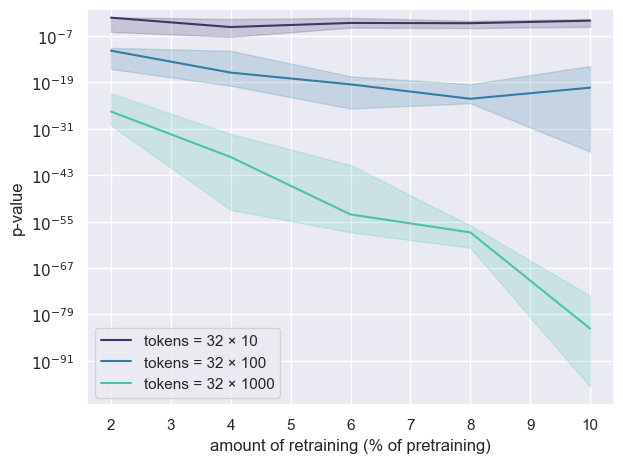

In [81]:
base_config = {
        "save_dir": './not-a-test',
        "n_partial_0": 450000,
        "n_base": 500000,
        "seed": 42,
        "num_partial_models": 5,
        "num_shuffles": 10,
        "n_finetune": 0,
        "finetune_on_test": "false",
    }

plot_configs,plot_names = [],[]
for n_sample in [10,100,1000]:
    plot_config = {k : v for k,v in base_config.items()}
    plot_config["n_sample"] = n_sample

    plot_configs.append(plot_config)
    plot_names.append(f"tokens = 32 × {n_sample}")
    
    
sweep_param = "partial_model_index"
sweep_values = [0,1,2,3,4]

colors = get_colors(3)

get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values, 
    x_transform=lambda x : (5-x)*2,
    xlabel="amount of retraining (% of pretraining)",
    colors=colors,
    save_path="../figures/main-tinystories-basic.png"
)

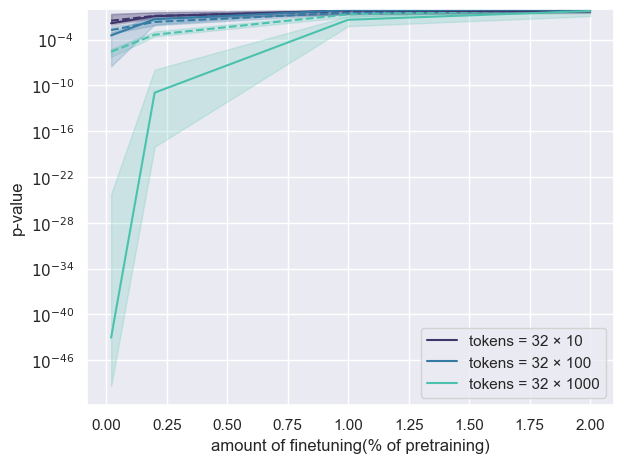

In [82]:
base_config = {
        "save_dir": './not-a-test',
        "n_partial_0": 450000,
        "n_base": 500000,
        "seed": 42,
        "num_partial_models": 5,
        "num_shuffles": 10,
        "partial_model_index": 4,
    }

plot_configs,plot_names = [],[]
styles,in_legend = [],[]
n_sample_sweep = [10, 100, 1000]
for finetune_on_test in ["false","true"]:
    for n_sample in n_sample_sweep:
        plot_config = {k : v for k,v in base_config.items()}
        plot_config["n_sample"] = n_sample
        plot_config["finetune_on_test"] = finetune_on_test

        if finetune_on_test == "false":
            in_legend.append(False)
            styles.append('--')
        else:
            in_legend.append(True)
            styles.append('-')
    
        plot_configs.append(plot_config)
        plot_names.append(f"tokens = 32 × {n_sample}")

colors = get_colors(len(n_sample_sweep)) * 2
    
sweep_param = "n_finetune"
sweep_values = [100, 1000, 5000, 10000]

get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values, 
    x_transform=lambda x : (x/500000)*100,
    xlabel="amount of finetuning(% of pretraining)",
    styles=styles,
    colors=colors,
    in_legend=in_legend,
    save_path="../figures/main-tinystories-finetune.png"
)

In [89]:
### APPENDIX PLOTS ###

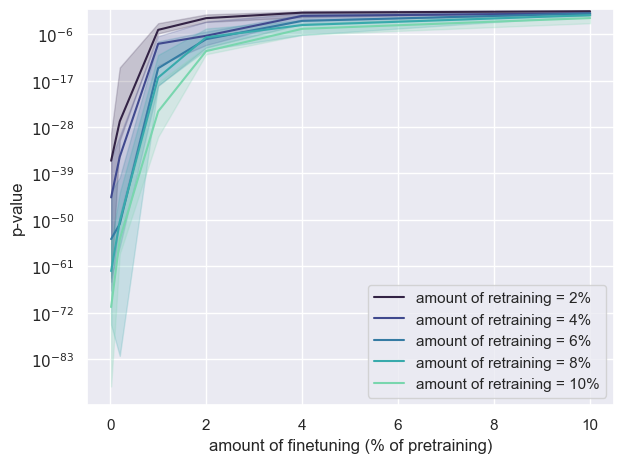

In [83]:
base_config = {
        "save_dir": './not-a-test',
        "n_partial_0": 450000,
        "n_base": 500000,
        "n_sample": 5000,
        "seed": 42,
        "num_partial_models": 5,
        "num_shuffles": 10,
        "finetune_on_test": "true",
    }

plot_configs,plot_names = [],[]
for partial_model_index in [4,3,2,1,0]:
    plot_config = {k : v for k,v in base_config.items()}
    plot_config["partial_model_index"] = partial_model_index

    plot_configs.append(plot_config)
    plot_names.append(f"amount of retraining = {int((5-partial_model_index)/0.5)}%")
    
    
sweep_param = "n_finetune"
sweep_values = [100, 1000, 5000, 10000, 20000, 50000]

colors = get_colors(5)

get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values, 
    x_transform=lambda x : (x/500000)*100,
    xlabel="amount of finetuning (% of pretraining)",
    colors=colors,
    save_path="../figures/appendix-tinystories-finetune.png"
)

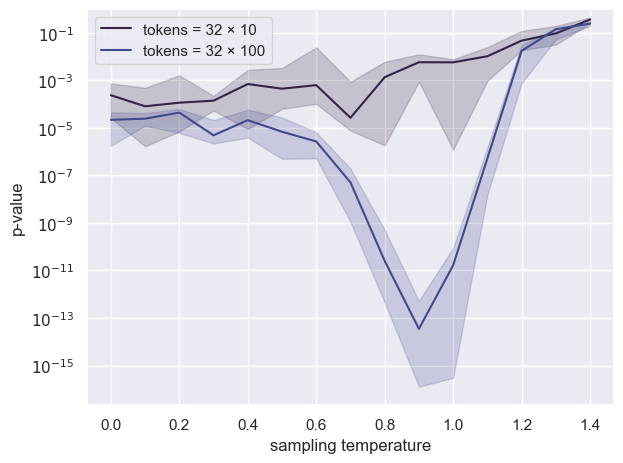

In [84]:
base_config = {
        "save_dir": "./not-a-test",
        "n_partial_0": 450000,
        "n_base": 500000,
        "seed": 42,
        "num_partial_models": 5,
        "partial_model_index": 4,
        "num_shuffles": 10,
        "n_finetune": 0,
        "finetune_on_test": "false",
}

plot_configs,plot_names = [],[]
for n_sample in [10,100]:
    plot_config = {k : v for k,v in base_config.items()}
    plot_config["n_sample"] = n_sample

    plot_configs.append(plot_config)
    plot_names.append(f"tokens = 32 × {n_sample}")
    
    
sweep_param = "temperature"
sweep_values = [0.1 * x for x in range(15)]

colors = get_colors(5)

get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values, 
    xlabel="sampling temperature",
    colors=colors,
    save_path="../figures/appendix-tinystories-temperature.png"
)

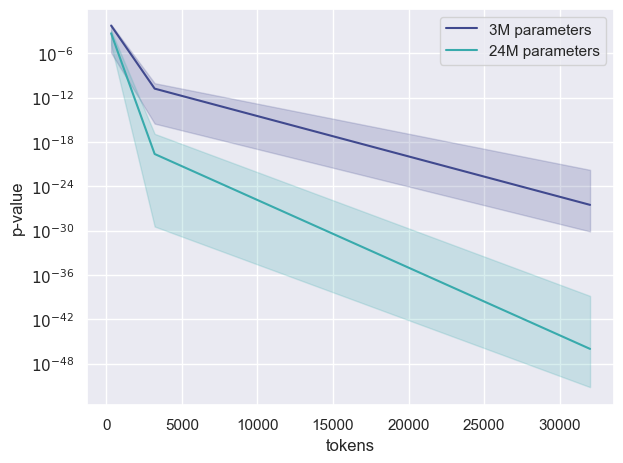

In [4]:
base_config = {
    "save_dir": './not-a-test',
    "n_partial_0": 450000,
    "n_base": 500000,
    "seed": 42,
    "num_partial_models": 5,
    "num_shuffles": 10,
    "n_finetune": 0,
    "finetune_on_test": "false",
    "partial_model_index": 4,
}
model_configs = {
    "3M": {},
    "24M": {
        "hidden_size": 512,
        "intermediate_size": 1024,
        "num_hidden_layers": 8,
    }
}

plot_configs,plot_names = [],[]
for model_size in ["3M","24M"]:
    plot_config = {k : v for k,v in base_config.items()}
    plot_config.update(model_configs[model_size])

    plot_configs.append(plot_config)
    plot_names.append(f"{model_size} parameters")
    
    
sweep_param = "n_sample"
sweep_values = [10,100,1000]

colors = get_colors(2)

get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values, 
    x_transform=lambda x : x * 32,
    xlabel="tokens",
    colors=colors,
    save_path="../figures/appendix-tinystories-model-size-basic.png"
)

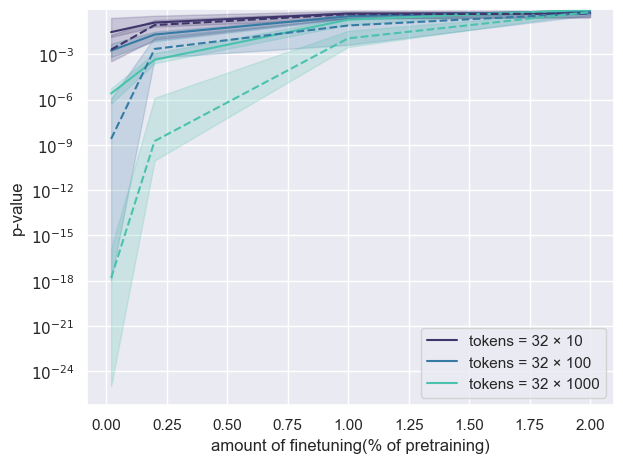

In [5]:
base_config = {
    "save_dir": './not-a-test',
    "n_partial_0": 450000,
    "n_base": 500000,
    "seed": 42,
    "num_partial_models": 5,
    "num_shuffles": 10,
    "partial_model_index": 4,
}

model_configs = {
    "3M": {},
    "24M": {
        "hidden_size": 512,
        "intermediate_size": 1024,
        "num_hidden_layers": 8,
    }
}

plot_configs,plot_names = [],[]
styles,in_legend = [],[]
n_sample_sweep = [10, 100, 1000]

for size in ["3M","24M"]:
    for n_sample in n_sample_sweep:
        plot_config = {k : v for k,v in base_config.items()}
        plot_config["n_sample"] = n_sample
        plot_config.update(model_configs[size])

        if size == "24M":
            in_legend.append(False)
            styles.append('--')
        else:
            in_legend.append(True)
            styles.append('-')
    
        plot_configs.append(plot_config)
        plot_names.append(f"tokens = 32 × {n_sample}")

colors = get_colors(len(n_sample_sweep)) * 2
    
sweep_param = "n_finetune"
sweep_values = [100, 1000, 5000, 10000]

get_plot(
    plot_configs, 
    plot_names, 
    sweep_param, 
    sweep_values, 
    x_transform=lambda x : (x/500000)*100,
    xlabel="amount of finetuning(% of pretraining)",
    styles=styles,
    colors=colors,
    in_legend=in_legend,
    save_path="../figures/appendix-tinystories-model-size-finetune.png"
)